In [132]:

import numpy as np 
from scipy.constants.constants import C2K, K2C
import math
from scipy import optimize as opt # for optimization


In [133]:
 #Calculating equation of state and fugacity

#Solve Equation of state, Eq 2 of Pitzer and Sterner (1994)
#Returns pressure in Pa
def eos(T, V):
    den = 1/V
    R = 8314472
    var_num = cs[2]+2*cs[3]*den+3*cs[4]*math.pow(den,2)+4*cs[5]*math.pow(den,3)
    var_denom = math.pow((cs[1]+cs[2]*den+cs[3]*math.pow(den,2)+cs[4]*math.pow(den,3)+cs[5]*math.pow(den,4)),2)
    pressure=den+cs[0]*math.pow(den,2)-math.pow(den,2)*(var_num/var_denom)
    pressure= pressure + (cs[6]*math.pow(den,2)*math.exp(-cs[7]*den)+cs[8]*math.pow(den,2)*math.exp(-cs[9]*den))
    pressure = pressure*(R*T) #pressure in Pa
    return pressure

#Solve for fugacity, Eq 1 of Pitzer and Sterner (1994)
#Returns fugacity in MPa
def PSfug(P,T,V):
    den=1/V;
    R=8314472;
    quotient = cs[0]*den+(1/(cs[1]+cs[2]*den+cs[3]*math.pow(den,2)+cs[4]*math.pow(den,3)+cs[5]*math.pow(den,4))-1/cs[1])
    quotient-= cs[6]/cs[7]*(math.exp(-cs[7]*den)-1)
    quotient-= cs[8]/cs[9]*(math.exp(-cs[9]*den)-1)
    lnf=(math.log(den)+ quotient+P/(den*R*T))+math.log(R*T)-1
    return math.exp(lnf)/1e6 # fugacity in MPa

#Optimizing equation to solve for volume
def fugacity_calculator(temperature,pressure):

    def fun(v):
        return eos(temperature, v)- pressure
    volume = opt.brentq(fun, 5, 30) #Volume in cc/mol

    #Calculate fugacity 
    fugacity = PSfug(pressure, temperature, volume)
    
    return fugacity


In [134]:
PScoeff = np.zeros([10,10])

PScoeff[0][2]=0.24657688*math.pow(10,6)
PScoeff[0][3]=0.51359951*math.pow(10,2) 
PScoeff[1][2]=0.58638965*math.pow(10,0) 
PScoeff[1][3]=-0.28646939*math.pow(10,-2) 
PScoeff[1][4]=0.31375577*math.pow(10,-4) 
PScoeff[2][2]=-0.62783840*math.pow(10,1) 
PScoeff[2][3]=0.14791599*math.pow(10,-1) 
PScoeff[2][4]=0.35779579*math.pow(10,-3) 
PScoeff[2][5]=0.15432925*math.pow(10,-7) 
PScoeff[3][3]=-0.42719875*math.pow(10,0) 
PScoeff[3][4]=-0.16325155*math.pow(10,-4) 
PScoeff[4][2]=0.56654978*math.pow(10,4) 
PScoeff[4][3]=-0.16580167*math.pow(10,2) 
PScoeff[4][4]=0.76560762*math.pow(10,-1) 
PScoeff[5][3]=0.10917883*math.pow(10,0) 
PScoeff[6][0]=0.38878656*math.pow(10,13) 
PScoeff[6][1]=-0.13494878*math.pow(10,9) 
PScoeff[6][2]=0.30916564*math.pow(10,6)
PScoeff[6][3]=0.75591105*math.pow(10,1) 
PScoeff[7][2]=-0.65537898*math.pow(10,5) 
PScoeff[7][3]=0.18810675*math.pow(10,3) 
PScoeff[8][0]=-0.14182435*math.pow(10,14) 
PScoeff[8][1]=0.18165390*math.pow(10,9) 
PScoeff[8][2]=-0.19769068*math.pow(10,6)
PScoeff[8][3]=-0.23530318*math.pow(10,2)
PScoeff[9][2]=0.92093375*math.pow(10,5)
PScoeff[9][3]=0.12246777*math.pow(10,3)

cs = np.zeros([10]) 

def calculate_coefficient_table(temperature):
    for i in range(0, len(PScoeff)):
        cs[i]=PScoeff[i][0]*math.pow(temperature,-4)+PScoeff[i][1]*math.pow(temperature,-2)\
        +PScoeff[i][2]*math.pow(temperature,-1)\
        +PScoeff[i][3]+PScoeff[i][4]*temperature+PScoeff[i][5]*math.pow(temperature,2)

class FugacityCalculator():
    def __init__(self, temperature_values, pressure_values):
        if len(temperature_values) > 1:
            self.temperature = C2K(np.arange(temperature_values[0],temperature_values[1]+1))
        else:# len(temperature_values) == 1:
            self.temperature = C2K(temperature_values)
        self.pressure = self.convert_mpa_to_pa(pressure_values)
        self.temperature_and_pressure = self.combine_temp_and_pressure_values()
    
    @staticmethod
    def convert_mpa_to_pa(pressure_values):
        if len(pressure_values) > 1:
            pressures = np.arange(pressure_values[0],pressure_values[1]+1)
            for i,p in enumerate(pressures):
                Ppa = p*1.0E6
                pressures[i] = Ppa
        else:# len(pressure_values) == 1:
            pressures = np.array(pressure_values)*1.0E6
        return pressures 
    
    #This still only works with a constant pressure value. Put on fix-it list.
    def combine_temp_and_pressure_values(self):
        all_values = []         
        if len(self.temperature)>1:    
            for i,temp in enumerate(self.temperature):
                temp_and_pressure = (temp, float(self.pressure))
                all_values.append(temp_and_pressure)
        else:
              all_values = (float(self.temperature), float(self.pressure))
        return all_values
        
    def calculate_fugacity(self): 
        temperature_pressure_fugacity = []
        if len(self.temperature)>1:
            for t,p in self.temperature_and_pressure: 
                calculate_coefficient_table(t)
                fugacity = fugacity_calculator(t,p)
                values = (t,p,fugacity)
                temperature_pressure_fugacity.append(values)
        
        else:
            calculate_coefficient_table(self.temperature_and_pressure[0])
            fugacity = fugacity_calculator(self.temperature_and_pressure[0], self.temperature_and_pressure[1])
            temperature_pressure_fugacity = [(self.temperature_and_pressure[0], self.temperature_and_pressure[1], fugacity)]
        return temperature_pressure_fugacity
            
        
            
    
    

In [135]:
CONSTANT_B = 2451 #2451 (Holyoke 2010) #3631 (Stipp and Tullis, 2003)
EXPONENT = -1.26


FLOW_LAWS = {
    "KT84": {"A": 2.2E-6, "n": 2.7, "Q": 1.2E5},
    'GT95wm': {"A": 1.8E-8, "n": 4, "Q": 1.37E5},
    'J84': {"A": 2.88E-3, "n": 1.8, "Q": 1.51E5},
    'K89': {"A": 1.1E-6, "n": 2.7, "Q": 1.34E5},
    'HC82': {"A": 1.99E-2, "n": 1.8, "Q": 1.67E5},
    'LP92g': {"A": 6.6E-8, "n": 3.1, "Q": 1.35E5},
    'LP92a': {"A": 3.98E-10, "n": 4, "Q": 1.35E5},
    "H01":  {"A": 6.3E-12, "n": 4, "Q": 1.35E5}, 
    "RB04": {"A": 1.2E-5, "n": 2.97, "Q": 2.42E5}
    }

def calculate_differential_stress(grain_size):
    differential_stress = []
    for grain in grain_size:
        part = (math.log(grain)-math.log(CONSTANT_B))/EXPONENT
        part2 = math.exp(part)
        differential_stress.append(part2)
    return differential_stress

def calculate_strain_rate(differential_stress, fugacity_calculations, flow_law=None): 

    strain_rate = []
    
    for temperature, pressure, fugacity in fugacity_calculations:
        for stress in differential_stress:
            sr = (FLOW_LAWS[flow_law]['A']*np.power(stress, FLOW_LAWS[flow_law]['n'])*np.power(fugacity,1)*np.exp(-FLOW_LAWS[flow_law]['Q']/(8.3144598*temperature)))
            srn = np.float64(sr).item()
            strain_rate.append(srn)
    return strain_rate

def calculate_slip_rate(strain_rate, width): #width in m, output of mm/yr
    velocities = []
    
    for w in width: 

        for strain in strain_rate:
        
            vel = w*1000*31536000*strain
            velocities.append(vel)
        
    return velocities

In [136]:
temp = [300, 600]
pressure = [400]
width = [30]
grain_size = [12]


f = FugacityCalculator(temp,pressure)
fugacity_calculations = f.calculate_fugacity()

# #extract temp values
temperature = []
for t in range(0, len(fugacity_calculations)):
    xx = K2C(fugacity_calculations[t][0])
    temperature.append(xx)


## Calculate strain rate and differential stress
s = calculate_differential_stress(grain_size)
# print(s)
sr = calculate_strain_rate(s, fugacity_calculations, flow_law='H01')
v = calculate_slip_rate(sr, width)

print(s)
# print(sr)
# print(v)


[68.14938743596466]


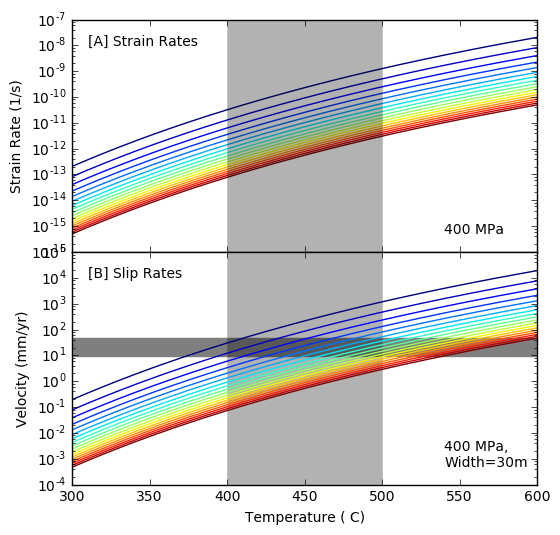

In [423]:
# -*- coding: utf-8 -*-
#Plotting 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages



temp = [300, 600]
pressure = [400]
grain_size = range(3,21)#[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]

f = FugacityCalculator(temp,pressure)
fugacity_calculations = f.calculate_fugacity()

#Calculate strain and slip rates at these grain sizes and shear zone width
accumulated_strain_rates = []
accumulated_slip_rates = []
for i, grain in enumerate(grain_size):
    s = calculate_differential_stress([grain])
    sr = calculate_strain_rate(s, fugacity_calculations, flow_law='H01')
    accumulated_strain_rates.append(sr)
    v = calculate_slip_rate(sr, width)
    accumulated_slip_rates.append(v)


    
    
#Creat plot and labels

fig = plt.figure(figsize=(6,6))
sub1 = fig.add_subplot(2,1,1)
sub1.text(310, 1.0E-8, '[A] Strain Rates ',size=10)
sub1.text(540, 5.0E-16, '400 MPa',size=10)
sub1.set_ylabel('Strain Rate (1/s)')


colors=iter(cm.jet(np.linspace(0,1,len(grain_size))))
for i, grain in enumerate(grain_size):
    sub1.plot(temperature, accumulated_strain_rates[i], color=next(colors))
    sub1.set_yscale('log')

#add temperature range to plot
x=[450,450]
y=[1.0E-8,1.0E-16]
sub1.plot(x,y,linestyle='-', color='k', linewidth=112, alpha=0.3)   
    
sub2 = fig.add_subplot(2,1,2, sharex=sub1)
sub2.text(310, 10000, '[B] Slip Rates',size=10)
sub2.text(540, 0.0005, '400 MPa,\nWidth=30m',size=10)
sub2.set_xlabel('Temperature ( C)')
sub2.set_ylabel("Velocity (mm/yr)")

plt.setp(sub1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace = 0.001)

#Add typical slip rates around the world
y=[22, 22]
x=[300, 600]
sub2.plot(x, y, linestyle='-', color='k', linewidth=14, alpha=0.5)
#add temperature range to plot
x=[450,450]
y=[1.0E4,1.0E-4]
sub2.plot(x,y,linestyle='-', color='k', linewidth=112, alpha=0.3)

colors=iter(cm.jet(np.linspace(0,1,len(grain_size))))
for i, grain in enumerate(grain_size):
    sub2.plot(temperature, accumulated_slip_rates[i], color=next(colors))
    sub2.set_yscale('log')
    


#Export PDF file
pdf = PdfPages('Strain_Slip_Rates.pdf')
pdf.savefig(fig)
pdf.close()


plt.show()




8

In [210]:
## Working with the simulators

temp = [450]
pressure = [400]
grain_size = [7]#range(3,21)#[5,6,7,8,9,10,11,12,13,14,15,30] #List of grainsizes 
width = [30]

#Calculate fugacity
f = FugacityCalculator(temp,pressure)
fugacity_calculations = f.calculate_fugacity()


#Calculate strain and slip rates at these grain sizes and shear zone width
accumulated_strain_rates = []
accumulated_slip_rates = []
for i, grain in enumerate(grain_size):
    s = calculate_differential_stress([grain])
    sr = calculate_strain_rate(s, fugacity_calculations, flow_law='H01')
    accumulated_strain_rates.append(sr)
    v = calculate_slip_rate(sr, width)
    accumulated_slip_rates.append(v)
    
print(v, sr)

x = simulate_slip_and_strain(35, 0.5, 5.557674678407064e-13)
x

([14.73072143854492], [1.557027041956803e-11])


([0.6134339003038581], [0.0])

In [284]:
## Simulators, this is for future work/ work in progress.
from mpmath import mp

#define conversion from mm/yr to mm/sec
conv = float(mp.fdiv(1, 31536000))

#grain_size = [5, 6, 7, 8, 9, 10]
def simulate_width(slip_rate, strain_rate):
    #v=w*e
    width = []
    for slip in slip_rate:
        for strain in strain_rate:
            w = (slip/(strain*31536000))/1000
            if w < 30 or w == 30:
                
                width.append(w)
            else:
                width.append(str("ERROR: Too wide"))
            
    return width




def simulate_slip_and_strain(width, slip_rate=14.7, strain_rate=1.557027041956803e-11):
    slip_rate = []
    strain = []
    width = [width]
        
    print(len(slip_rate))
    
    if len(slip_rate) == 1: #constant stress condition
        for w in width:
            st = slip_rate*conv/(w*1000)
        return st
    
    elif len(strain_rate) == 1: #constant strain rate condition
        for w in width:
            sl = strain_rate*31536000*w*1000
        return sl
    
    


In [417]:
width=30
strain_rate=1.5E-11

def simulator(width, strain_rate):
    v=15.
    
    w=(v/1000)/(strain_rate*31536000)
    
    e=(v/31536000)/(width*1000)

    return w, e, v

simulator(width, strain_rate)





(31.709791983764585, 1.5854895991882293e-11, 15.0)

In [ ]:
x=5
y=10

v=

In [409]:
#Measuring grain sizes
#Sample PS030
d = [2.9, 2.6, 0.8, 2.9, 1.8, 2.4, 1.2, 1.4, 1.4, 0.8, 1.5, 4.7, 1.5, 1.0, 0.6,
     0.7, 0.4, 1.9, 3, 0.4, 0.3, 0.7, 0.5, 0.9, 0.8]
#note: resoultion is ~0.25mm or 2 microns
conversion = 10689.3
#micron = d*conversion

micron = []
for i in range(0, len(d)):
    m = d[i]*(300/35.631)
    mr = round(m,2)
    micron.append(mr)

print(micron)
print(len(micron), max(micron), min(micron))
print(round(np.mean(micron)))
print(round(np.std(micron)))


[24.42, 21.89, 6.74, 24.42, 15.16, 20.21, 10.1, 11.79, 11.79, 6.74, 12.63, 39.57, 12.63, 8.42, 5.05, 5.89, 3.37, 16.0, 25.26, 3.37, 2.53, 5.89, 4.21, 7.58, 6.74]
(25, 39.57, 2.53)
12.0
9.0
